In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)

In [19]:
# Cargar datos
data = pd.read_csv('train.csv')

# Crear variable categórica basada en rangos de precios
bins = [0, 150000, 300000, float('inf')]
labels = ['Económica', 'Intermedia', 'Cara']
data['PriceCategory'] = pd.cut(data['SalePrice'], bins=bins, labels=labels)

# Crear variables dicotómicas
data['is_expensive'] = (data['PriceCategory'] == 'Cara').astype(int)
data['is_medium'] = (data['PriceCategory'] == 'Intermedia').astype(int)
data['is_economic'] = (data['PriceCategory'] == 'Económica').astype(int)

# Separar características y objetivo
X = data.drop(['SalePrice', 'PriceCategory', 'is_expensive', 'is_medium', 'is_economic'], axis=1)
y = data['PriceCategory']
y_binary = data['is_expensive']

# Convertir variables categóricas a dummy variables
X = pd.get_dummies(X)

# Manejar valores faltantes
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Estandarizar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_binary = scaler.fit_transform(X_train_binary)
X_test_binary = scaler.transform(X_test_binary)

Puntuaciones de validación cruzada: [0.95726496 0.95299145 0.96581197 0.9527897  0.95708155]
Precisión media: 0.9572

Matriz de Confusión:
[[260   8]
 [  4  20]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       268
           1       0.71      0.83      0.77        24

    accuracy                           0.96       292
   macro avg       0.85      0.90      0.87       292
weighted avg       0.96      0.96      0.96       292

AUC-ROC: 0.9684

Variables más importantes:
                 Variable  Coeficiente
4             OverallQual     1.232959
27             GarageArea     0.811316
16              GrLivArea     0.722236
17           BsmtFullBath     0.711864
51        LandContour_HLS     0.711052
167          ExterQual_Ex     0.676272
86   Neighborhood_StoneBr     0.664958
53        LandContour_Lvl     0.646876
19               FullBath     0.617422
13               1stFlrSF     0.589312


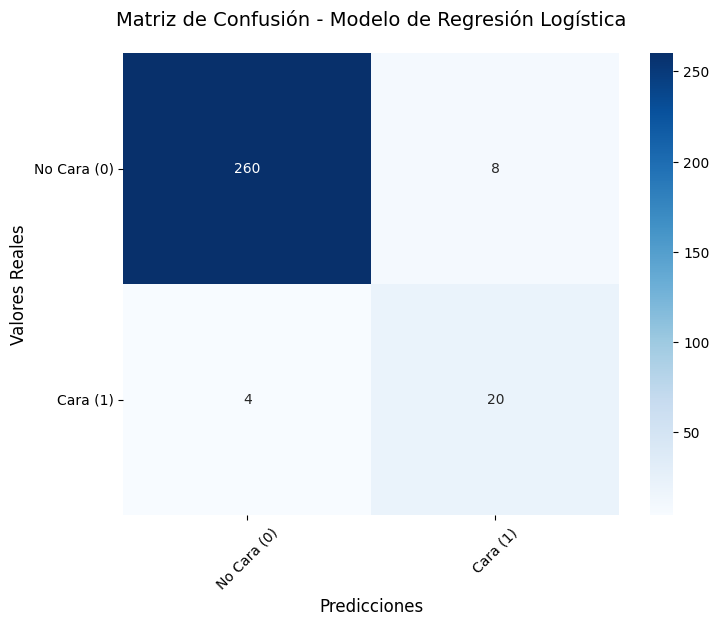

In [20]:
# Crear y entrenar modelo
log_reg_binary = LogisticRegression(max_iter=1000, random_state=42)
log_reg_binary.fit(X_train_binary, y_train_binary)

# Validación cruzada
cv_scores = cross_val_score(log_reg_binary, X_train_binary, y_train_binary, cv=5)
print(f"Puntuaciones de validación cruzada: {cv_scores}")
print(f"Precisión media: {cv_scores.mean():.4f}")

# Evaluar en conjunto de prueba
y_pred_binary = log_reg_binary.predict(X_test_binary)
y_proba_binary = log_reg_binary.predict_proba(X_test_binary)[:, 1]

# Métricas de evaluación
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("\nReporte de Clasificación:")
print(classification_report(y_test_binary, y_pred_binary))
print(f"AUC-ROC: {roc_auc_score(y_test_binary, y_proba_binary):.4f}")

# Análisis de coeficientes para identificar variables importantes
coef_df = pd.DataFrame({'Variable': X.columns, 'Coeficiente': log_reg_binary.coef_[0]})
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)
print("\nVariables más importantes:")
print(coef_df.head(10))

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Crear una visualización más profesional
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cara (0)', 'Cara (1)'], 
            yticklabels=['No Cara (0)', 'Cara (1)'])
plt.title('Matriz de Confusión - Modelo de Regresión Logística', fontsize=14, pad=20)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Valores Reales', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

C:\Users\danie\AppData\Roaming\Python\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Variables con potencial multicolinealidad (VIF > 5):
                  Variable        VIF
1               MSSubClass  35.000671
4              OverallQual   5.627546
6                YearBuilt  15.492023
9               BsmtFinSF1        inf
10              BsmtFinSF2        inf
..                     ...        ...
283  SaleCondition_AdjLand        inf
284   SaleCondition_Alloca        inf
285   SaleCondition_Family        inf
286   SaleCondition_Normal        inf
287  SaleCondition_Partial        inf

[254 rows x 2 columns]

Reporte de Clasificación (modelo regularizado):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       268
           1       0.70      0.67      0.68        24

    accuracy                           0.95       292
   macro avg       0.83      0.82      0.83       292
weighted avg       0.95      0.95      0.95       292



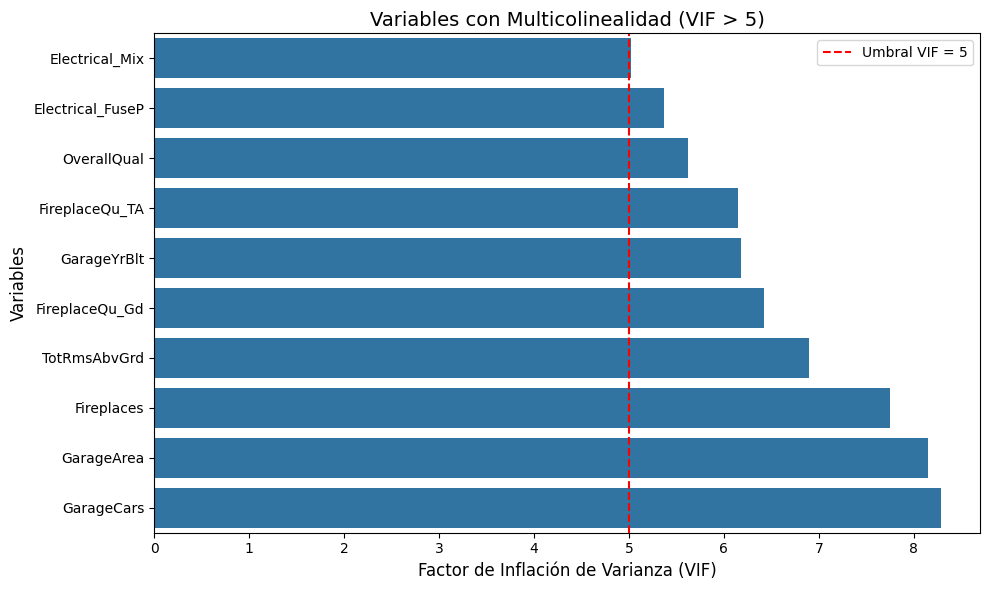

In [21]:
# Calcular VIF para detectar multicolinealidad
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Filtrar variables con alto VIF (generalmente > 5 o 10 indica multicolinealidad)
high_vif = vif_data[vif_data["VIF"] > 5]
print("\nVariables con potencial multicolinealidad (VIF > 5):")
print(high_vif)

log_reg_ridge = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42)
log_reg_ridge.fit(X_train_binary, y_train_binary)

# Evaluar modelo regularizado
y_pred_ridge = log_reg_ridge.predict(X_test_binary)
print("\nReporte de Clasificación (modelo regularizado):")
print(classification_report(y_test_binary, y_pred_ridge))

plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Variable', data=high_vif.sort_values('VIF', ascending=True).head(10))
plt.title('Variables con Multicolinealidad (VIF > 5)', fontsize=14)
plt.xlabel('Factor de Inflación de Varianza (VIF)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.axvline(x=5, color='r', linestyle='--', label='Umbral VIF = 5')
plt.legend()
plt.tight_layout()
plt.show()

Métricas de Clasificación
Exactitud (Accuracy): 0.9589
Precisión (Precision): 0.7143
Sensibilidad (Recall): 0.8333
Puntuación F1: 0.7692
AUC-ROC: 0.9684

Matriz de Confusión


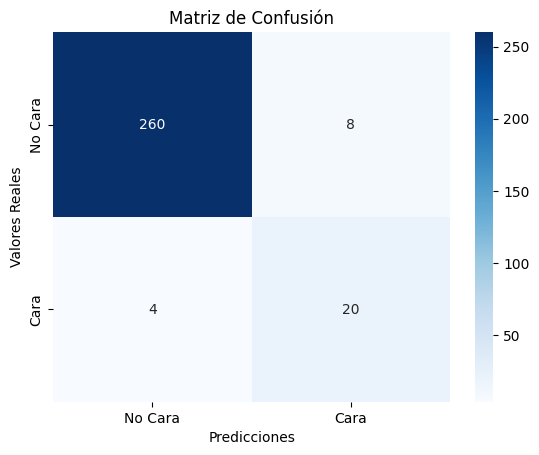


Reporte de Clasificación
              precision    recall  f1-score   support

     No Cara       0.98      0.97      0.98       268
        Cara       0.71      0.83      0.77        24

    accuracy                           0.96       292
   macro avg       0.85      0.90      0.87       292
weighted avg       0.96      0.96      0.96       292



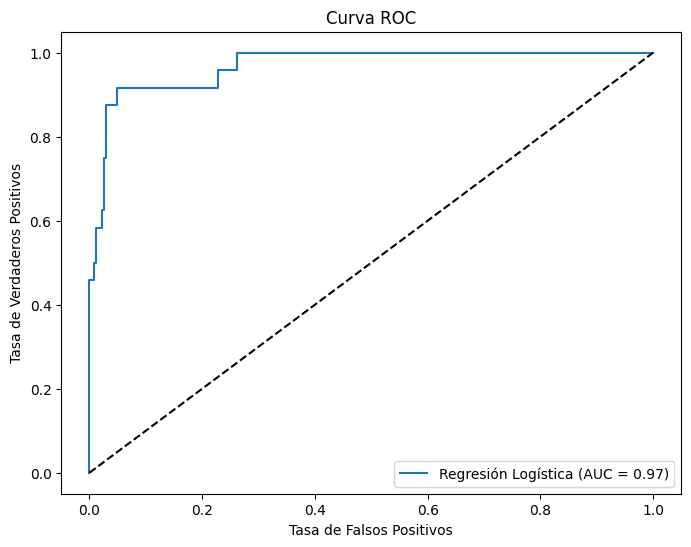

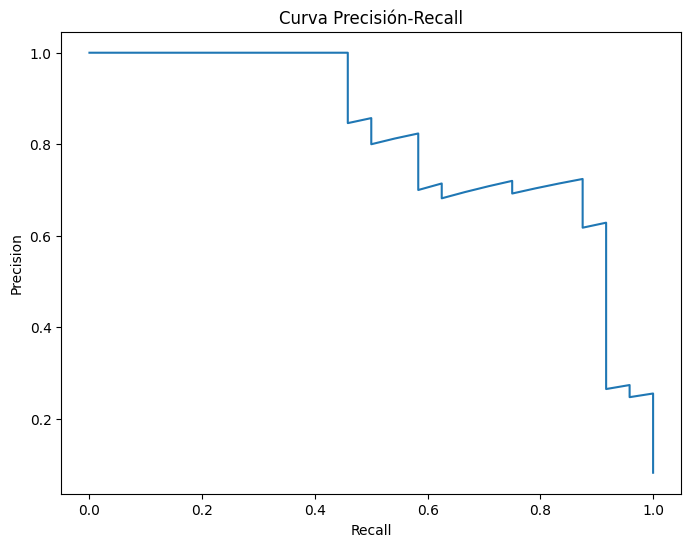

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = log_reg_binary.predict(X_test_binary)
y_proba = log_reg_binary.predict_proba(X_test_binary)[:, 1]

# Calcular métricas principales
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
roc_auc = roc_auc_score(y_test_binary, y_proba)

# Mostrar métricas
print("Métricas de Clasificación")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Puntuación F1: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}\n")

# Matriz de confusión detallada
print("Matriz de Confusión")
conf_matrix = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cara', 'Cara'], 
            yticklabels=['No Cara', 'Cara'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

# Reporte de clasificación completo
print("\nReporte de Clasificación")
print(classification_report(y_test_binary, y_pred, target_names=['No Cara', 'Cara']))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Regresión Logística (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Curva Precisión-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test_binary, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precisión-Recall')
plt.show()